# Exploration des données du corpus d'articles scientifiques

In [1]:
# Imports des bibliothèques et modules nécessaires
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')

# Ajouter le répertoire parent au chemin de recherche
sys.path.append(os.path.abspath('..'))

# Import des modules du projet
from src.config.config import load_config
from src.data_acquisition.data_loader import DataLoader
from src.data_acquisition.data_cleaner import DataCleaner
from src.data_acquisition.data_explorer import DataExplorer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL_7670\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Chargement des données

In [2]:
# Chargement de la configuration (par defaut, on peut par exemple en définir une par corpus etc dans le fichier ./config/config.py))
config = load_config()

# Chemin vers le fichier de données
data_path = Path("../data/raw/data_project.csv")

# Vérifier si le fichier existe
if not data_path.exists():
    raise FileNotFoundError(f"Le fichier {data_path} n'existe pas.")

# Créer un objet DataLoader
data_loader = DataLoader(config)

# Charger les données
df = data_loader.load_from_csv(data_path)

# Afficher les premières lignes
print(f"Dimensions du DataFrame: {df.shape}")
df.head()

Dimensions du DataFrame: (40596, 9)


,venue,abstract,authors,n_citation,references,title,year,id,class
0,international conference on human-computer int...,The purpose of this study is to develop a lear...,"['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...",0,"['51c7e02e-f5ed-431a-8cf5-f761f266d4be', '69b6...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
1,visual analytics science and technology,This paper describes the design and implementa...,"['Gareth Beale', 'Graeme Earl']",50,"['10482dd3-4642-4193-842f-85f3b70fcf65', '3133...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3
2,pattern recognition and machine intelligence,This article applied GARCH model instead AR or...,"['Altaf Hossain', 'Faisal Zaman', 'Mohammed Na...",50,"['2d84c0f2-e656-4ce7-b018-90eda1c132fe', 'a083...","Comparison of GARCH, Neural Network and Suppor...",2009,001c8744-73c4-4b04-9364-22d31a10dbf1,4
3,international conference on computer graphics ...,NaN,"['Rafael Álvarez', 'Leandro Tortosa', 'José-Fr...",0,NaN,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,2009,005ce28f-ed77-4e97-afdc-a296137186a1,5
4,international symposium on computer and inform...,NaN,"['Guzin Ulutas', 'Mustafa Ulutas', 'Vasif V. N...",0,"['5626736c-e434-4e2d-8405-54940fab88ab', '8e87...",Improved Secret Image Sharing Method By Encodi...,2011,00701b05-684f-45f9-b281-425abfec482c,8


## 2. Prétraitement des données

In [3]:
# Créer un objet DataCleaner
data_cleaner = DataCleaner(config)

# Convertir le DataFrame en liste de dictionnaires
documents = df.to_dict('records')

# Nettoyage des données
cleaned_docs = []
for doc in documents:
    # Assurer que tous les champs nécessaires existent
    if 'abstract' not in doc or doc['abstract'] is None:
        doc['abstract'] = ""
    
    # Nettoyer le texte de l'abstract
    if doc['abstract']:
        doc['abstract'] = data_cleaner.clean_text(doc['abstract'])
    
    # Convertir les références en liste si ce n'est pas déjà le cas
    if 'references' in doc and isinstance(doc['references'], str):
        # Si les références sont une chaîne sous forme de liste Python
        if doc['references'].startswith('[') and doc['references'].endswith(']'):
            try:
                doc['references'] = eval(doc['references'])
            except:
                doc['references'] = []
        else:
            # Sinon, diviser sur les virgules
            doc['references'] = [ref.strip() for ref in doc['references'].split(',') if ref.strip()]
    
    # Assurer que class est un entier
    if 'class' in doc and doc['class']:
        try:
            doc['class'] = int(doc['class'])
        except:
            doc['class'] = None
    
    # Convertir les auteurs en liste si ce n'est pas déjà le cas
    if 'authors' in doc and isinstance(doc['authors'], str):
        if doc['authors'].startswith('[') and doc['authors'].endswith(']'):
            try:
                doc['authors'] = eval(doc['authors'])
            except:
                doc['authors'] = []
        else:
            doc['authors'] = [author.strip() for author in doc['authors'].split(',') if author.strip()]

    if 'authors' in doc:
        doc['authors'] = data_cleaner.clean_authors_list(doc['authors'])

    cleaned_docs.append(doc)
    
    cleaned_docs.append(doc)

print(f"Nombre de documents après nettoyage: {len(cleaned_docs)}")
cleaned_docs[0]  # Afficher le premier document nettoyé

Nombre de documents après nettoyage: 81192


{'venue': 'international conference on human-computer interaction',
 'abstract': 'the purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net works more specifically we focus on the basic principles of network proto cols as the aim to develop our learning tool our tool gives students handson experience to help understand the basic principles of network protocols',
 'authors': ['Makoto Satoh',
  'Ryo Muramatsu',
  'Mizue Kayama',
  'Kazunori Itoh',
  'Masami Hashimoto',
  'Makoto Otani',
  'Michio Shimizu',
  'Masahiko Sugimoto'],
 'n_citation': 0,
 'references': ['51c7e02e-f5ed-431a-8cf5-f761f266d4be',
  '69b625b9-ebc5-4b60-b385-8a07945f5de9'],
 'title': 'Preliminary Design of a Network Protocol Learning Tool Based on the Comprehension of High School Students: Design by an Empirical Study Using a Simple Mind Map',
 'year': 2013,
 'id': '00127ee2-cb05-48ce-bc49-9de556b93346',
 'class': 3}

## 3. Analyse statistique de base

In [14]:
# Créer un objet DataExplorer
data_explorer = DataExplorer(cleaned_docs)

# Obtenir les statistiques de base
stats = data_explorer.get_basic_stats()

# Afficher les statistiques
print("Statistiques du corpus:")
for key, value in stats.items():
    if isinstance(value, dict):
        print(f"- {key}:")
        for subkey, subvalue in value.items():
            print(f"  - {subkey}: {subvalue}")
    else:
        print(f"- {key}: {value}")

Statistiques du corpus:
- num_documents: 81192
- num_authors: 81528
- avg_text_length: 62.87804217164253
- class_distribution:
  - 3: 4582
  - 4: 5000
  - 5: 10446
  - 8: 9624
  - 7: 9426
  - 1: 20198
  - 6: 7140
  - 2: 14776
- temporal_distribution:
  - 2013: 7154
  - 2011: 7140
  - 2009: 3704
  - 2003: 3856
  - 2014: 5338
  - 2002: 2392
  - 1979: 156
  - 2008: 4176
  - 2004: 3156
  - 2012: 7678
  - 2010: 3898
  - 2007: 4162
  - 2000: 2356
  - 2006: 3376
  - 1986: 570
  - 1988: 462
  - 1989: 538
  - 1994: 958
  - 1981: 254
  - 2015: 426
  - 1991: 826
  - 1997: 1502
  - 2005: 3662
  - 2001: 2094
  - 1998: 1806
  - 1990: 704
  - 1993: 978
  - 1992: 830
  - 1995: 1090
  - 1982: 198
  - 1999: 1908
  - 1996: 1160
  - 1985: 396
  - 1984: 312
  - 1987: 528
  - 2016: 226
  - 1969: 32
  - 2017: 50
  - 1974: 40
  - 1970: 14
  - 1977: 162
  - 1975: 66
  - 1983: 366
  - 1972: 52
  - 1973: 58
  - 1980: 136
  - 1976: 76
  - 1978: 106
  - 1971: 44
  - 1963: 2
  - 1960: 4
  - 1967: 4
  - 1968: 4
  - 

## 4. Visualisation de la distribution des classes

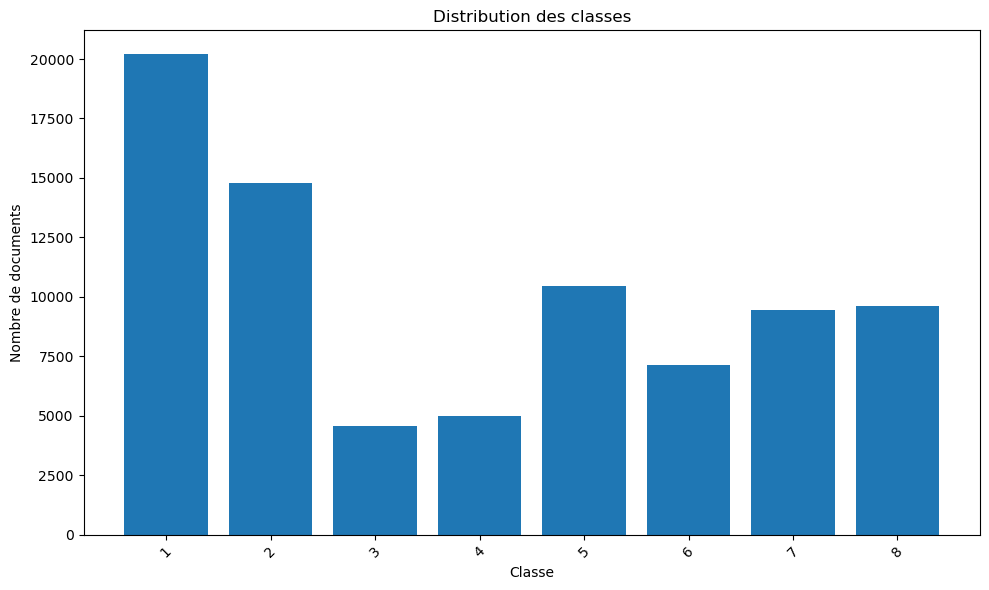


Classes et leurs descriptions:
- Classe 1: Intelligence Artificielle
- Classe 2: Science des Données
- Classe 3: Interface
- Classe 4: Vision par Ordinateur
- Classe 5: Réseau
- Classe 6: Informatique Théorique
- Classe 7: Applications Spécifiques
- Classe 8: Autres


In [15]:
# Visualiser la distribution des classes
data_explorer.visualize_class_distribution()

# Afficher les noms des classes avec leur description
class_descriptions = {
    1: "Intelligence Artificielle",
    2: "Science des Données",
    3: "Interface",
    4: "Vision par Ordinateur",
    5: "Réseau",
    6: "Informatique Théorique",
    7: "Applications Spécifiques",
    8: "Autres"
}

print("\nClasses et leurs descriptions:")
for cls, desc in class_descriptions.items():
    print(f"- Classe {cls}: {desc}")

## 5. Analyse temporelle

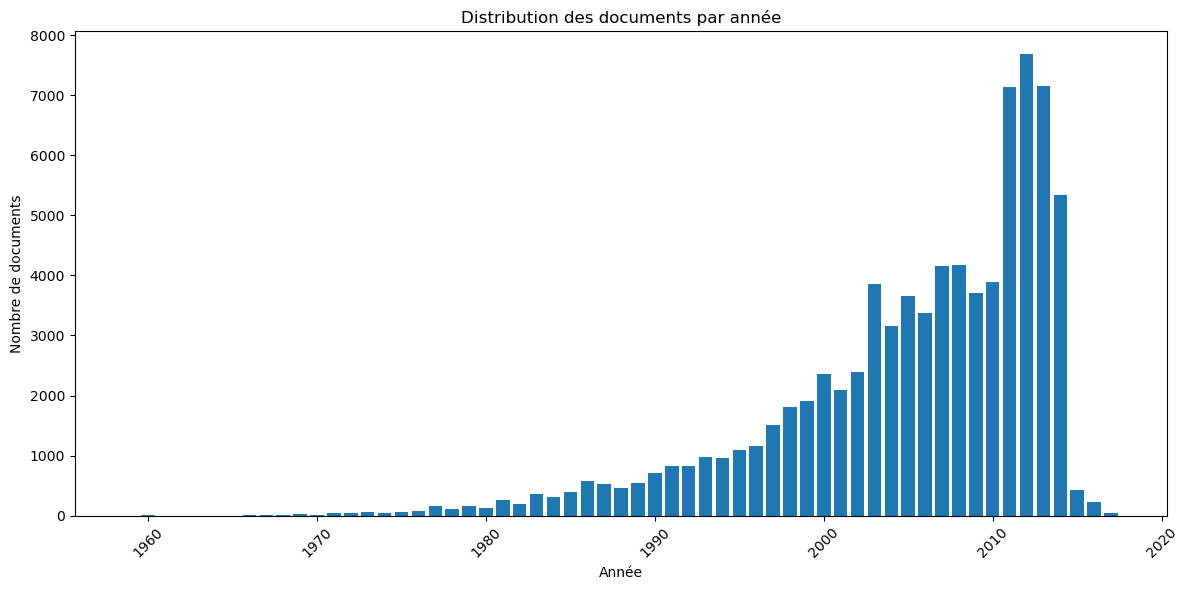

Année la plus ancienne: 1959
Année la plus récente: 2017
Année avec le plus de publications: 2012 avec 7678 documents


In [16]:
# Obtenir la distribution temporelle
temporal_dist = data_explorer._get_temporal_distribution()

# Convertir en DataFrame pour faciliter la visualisation
temp_df = pd.DataFrame(list(temporal_dist.items()), columns=['Year', 'Count'])
temp_df = temp_df.sort_values('Year')

# Visualiser la distribution temporelle
plt.figure(figsize=(12, 6))
plt.bar(temp_df['Year'], temp_df['Count'])
plt.title('Distribution des documents par année')
plt.xlabel('Année')
plt.ylabel('Nombre de documents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistiques sur la distribution temporelle
if len(temp_df) > 0:
    print(f"Année la plus ancienne: {temp_df['Year'].min()}")
    print(f"Année la plus récente: {temp_df['Year'].max()}")
    print(f"Année avec le plus de publications: {temp_df.loc[temp_df['Count'].idxmax(), 'Year']} avec {temp_df['Count'].max()} documents")

## 6. Analyse des auteurs

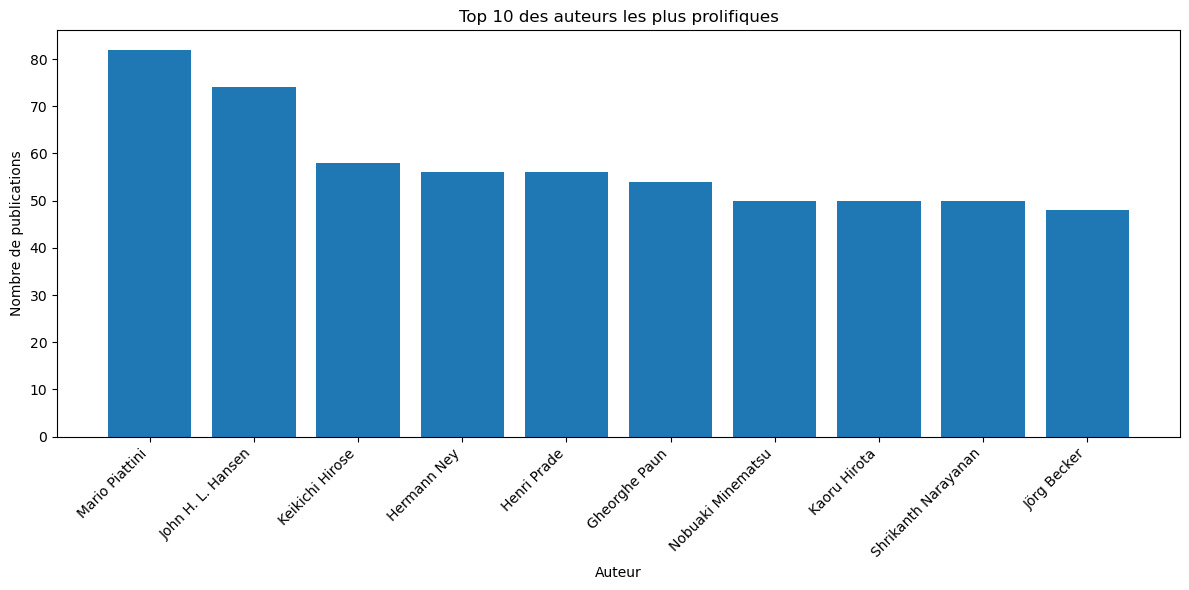

Nombre total d'auteurs: 81528
Nombre moyen d'auteurs par document: 2.85

Top 10 des auteurs les plus prolifiques:
- Mario Piattini: 82 publications
- John H. L. Hansen: 74 publications
- Keikichi Hirose: 58 publications
- Hermann Ney: 56 publications
- Henri Prade: 56 publications
- Gheorghe Paun: 54 publications
- Nobuaki Minematsu: 50 publications
- Kaoru Hirota: 50 publications
- Shrikanth Narayanan: 50 publications
- Jörg Becker: 48 publications


In [17]:
# Compter le nombre de publications par auteur
author_counts = Counter()
for doc in cleaned_docs:
    if 'authors' in doc and doc['authors']:
        for author in doc['authors']:
            author_counts[author] += 1

# Obtenir les auteurs les plus prolifiques
top_authors = author_counts.most_common(10)

# Visualiser les auteurs les plus prolifiques
plt.figure(figsize=(12, 6))
plt.bar([author for author, count in top_authors], [count for author, count in top_authors])
plt.title('Top 10 des auteurs les plus prolifiques')
plt.xlabel('Auteur')
plt.ylabel('Nombre de publications')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Statistiques sur les auteurs
print(f"Nombre total d'auteurs: {len(author_counts)}")
print(f"Nombre moyen d'auteurs par document: {sum(len(doc.get('authors', [])) for doc in cleaned_docs) / len(cleaned_docs):.2f}")
print("\nTop 10 des auteurs les plus prolifiques:")
for author, count in top_authors:
    print(f"- {author}: {count} publications")

## 7. Analyse des mots-clés

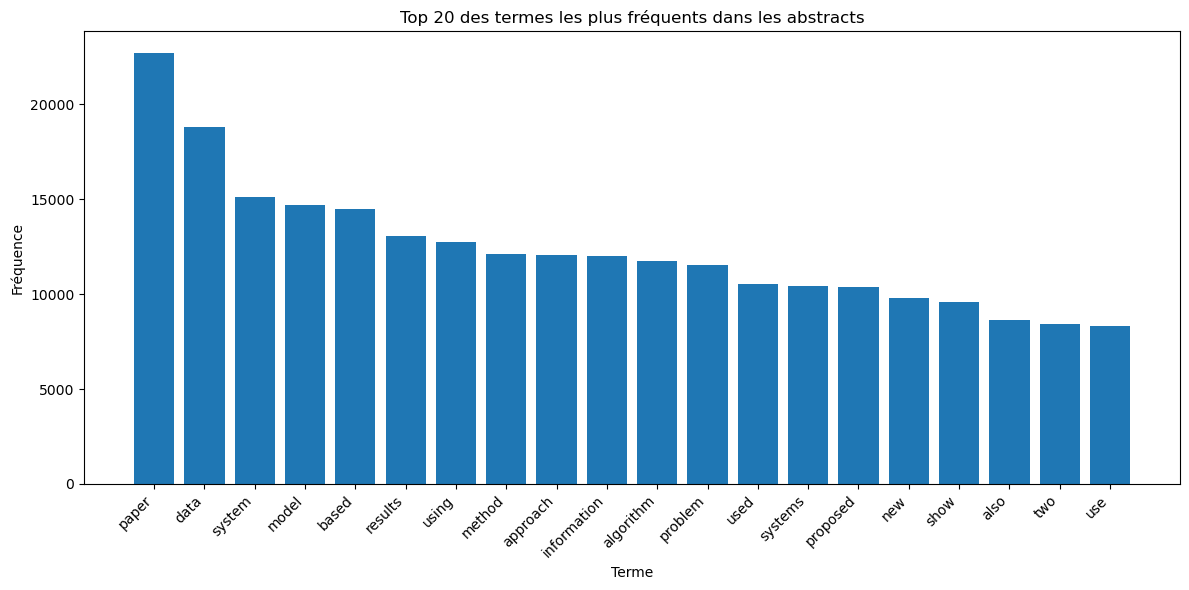

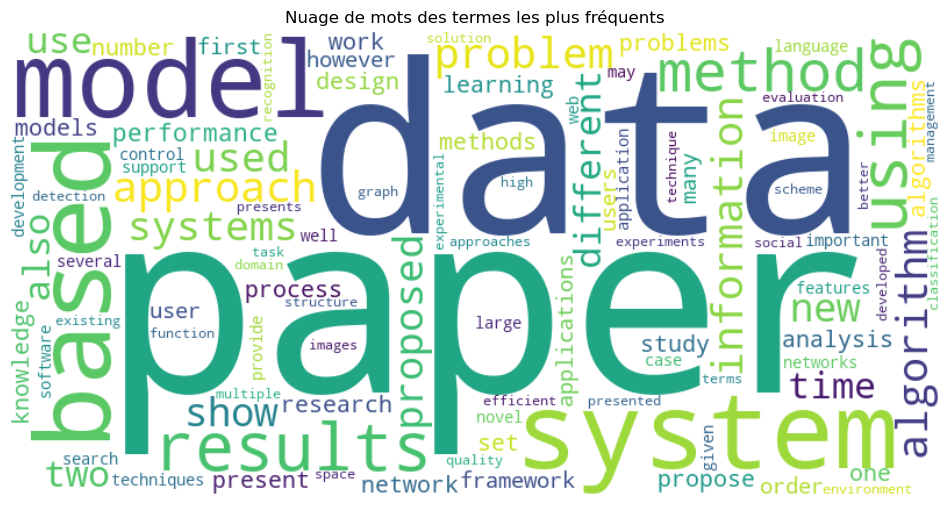

In [18]:
# Concaténer tous les abstracts
all_abstracts = " ".join([doc.get('abstract', '') for doc in cleaned_docs if doc.get('abstract')])

# Nettoyer le texte des abstracts
cleaned_abstracts = data_cleaner.clean_text(all_abstracts)

# Tokeniser
tokens = cleaned_abstracts.split()

# Supprimer les mots vides
tokens_without_stopwords = data_cleaner.remove_stop_words(tokens)

# Compter les occurrences des termes
term_counts = Counter(tokens_without_stopwords)

# Obtenir les termes les plus fréquents
top_terms = term_counts.most_common(20)

# Visualiser les termes les plus fréquents
plt.figure(figsize=(12, 6))
plt.bar([term for term, count in top_terms], [count for term, count in top_terms])
plt.title('Top 20 des termes les plus fréquents dans les abstracts')
plt.xlabel('Terme')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Créer un nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(term_counts)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des termes les plus fréquents')
plt.show()

## 8. Analyse des références

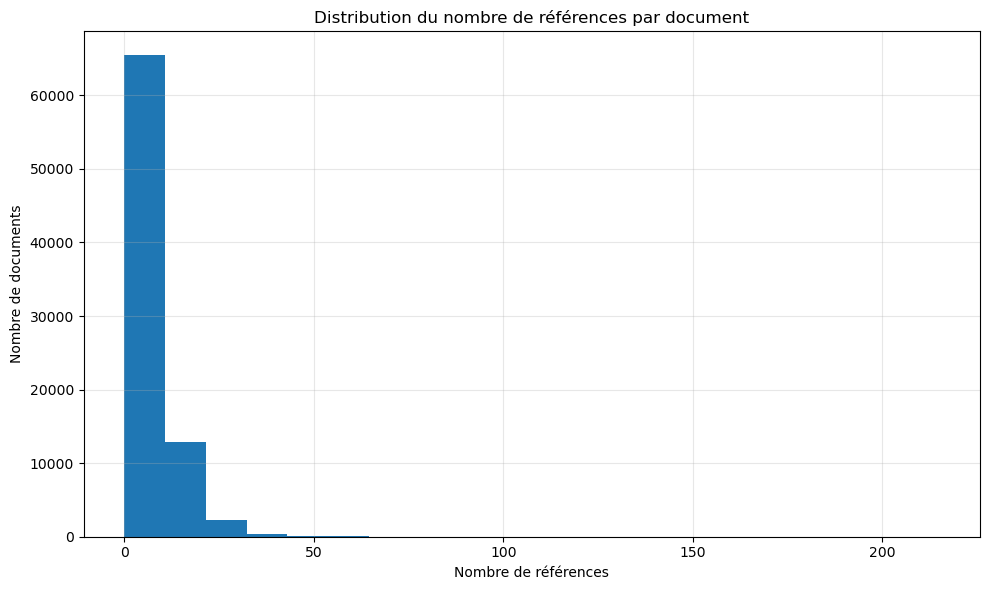

Nombre moyen de références par document: 5.58
Nombre médian de références par document: 3.00
Nombre maximum de références pour un document: 215
Nombre de documents sans références: 30306


In [19]:
# Calculer le nombre de références par document en gérant les cas où references est un (NaN)
ref_counts = []
for doc in cleaned_docs:
    refs = doc.get('references', [])
    if isinstance(refs, float):  # Vérifier si c'est un (NaN)
        ref_counts.append(0)     # Considérer qu'il n'y a aucune référence
    else:
        ref_counts.append(len(refs))

# Visualiser la distribution du nombre de références
plt.figure(figsize=(10, 6))
plt.hist(ref_counts, bins=20)
plt.title('Distribution du nombre de références par document')
plt.xlabel('Nombre de références')
plt.ylabel('Nombre de documents')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiques sur les références
print(f"Nombre moyen de références par document: {np.mean(ref_counts):.2f}")
print(f"Nombre médian de références par document: {np.median(ref_counts):.2f}")
print(f"Nombre maximum de références pour un document: {np.max(ref_counts)}")
print(f"Nombre de documents sans références: {sum(1 for count in ref_counts if count == 0)}")

## 9. Analyse des venues (lieux de publication)

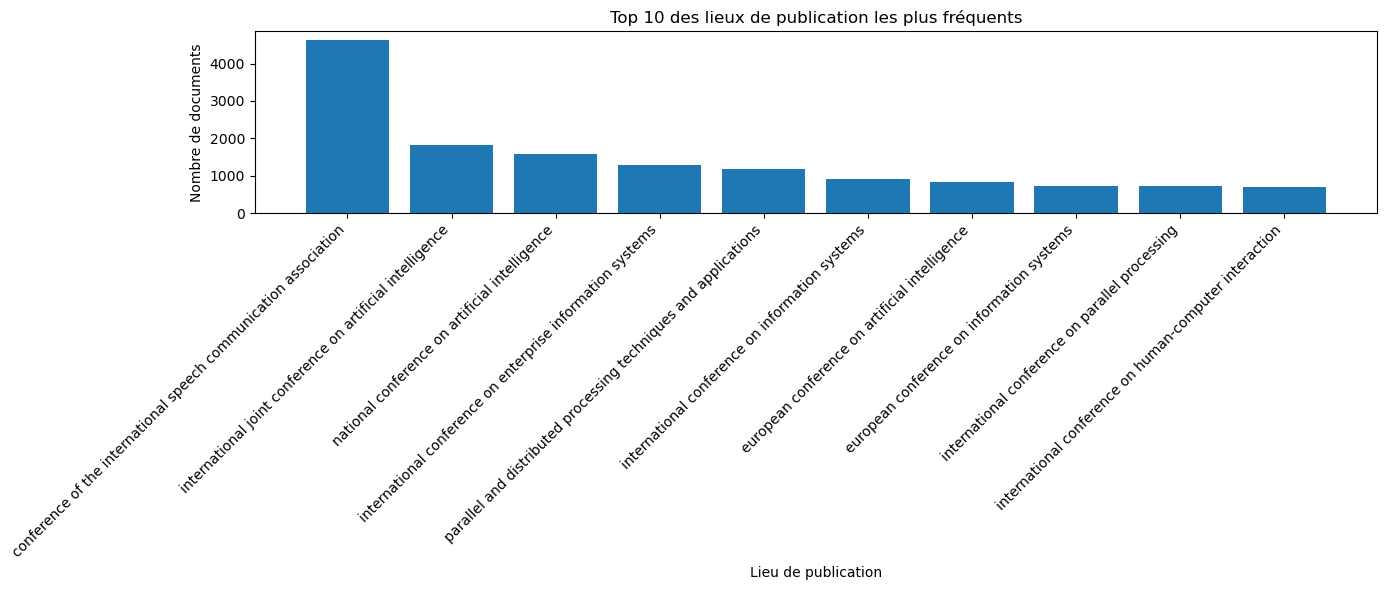

Nombre total de lieux de publication distincts: 1701

Top 10 des lieux de publication:
- conference of the international speech communication association: 4630 documents
- international joint conference on artificial intelligence: 1822 documents
- national conference on artificial intelligence: 1578 documents
- international conference on enterprise information systems: 1286 documents
- parallel and distributed processing techniques and applications: 1190 documents
- international conference on information systems: 924 documents
- european conference on artificial intelligence: 834 documents
- european conference on information systems: 722 documents
- international conference on parallel processing: 716 documents
- international conference on human-computer interaction: 714 documents


In [20]:
# Compter les occurrences des venues
venue_counts = Counter([doc.get('venue', '') for doc in cleaned_docs if doc.get('venue')])

# Obtenir les venues les plus fréquentes
top_venues = venue_counts.most_common(10)

# Visualiser les venues les plus fréquentes
plt.figure(figsize=(14, 6))
plt.bar([venue for venue, count in top_venues], [count for venue, count in top_venues])
plt.title('Top 10 des lieux de publication les plus fréquents')
plt.xlabel('Lieu de publication')
plt.ylabel('Nombre de documents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Statistiques sur les venues
print(f"Nombre total de lieux de publication distincts: {len(venue_counts)}")
print("\nTop 10 des lieux de publication:")
for venue, count in top_venues:
    print(f"- {venue}: {count} documents")

## 10. Traitements finaux et sauvegarde

In [21]:
# Initialisation des ressources NLTK
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("Téléchargement des ressources NLTK nécessaires...")
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')

# Créer l'instance de DataCleaner
cleaner = DataCleaner(config)

# Conversion de la liste df_cleaned en DataFrame
df_processed = pd.DataFrame(cleaned_docs)

# Remplacement des NaN dans 'references' par des listes vides
df_processed['references'] = df_processed['references'].apply(lambda x: [] if isinstance(x, float) else x)

# Suppression des stop words dans les abstracts
print("Suppression des stop words dans les abstracts...")
df_processed['abstract'] = df_processed['abstract'].apply(lambda text: 
    ' '.join(cleaner.remove_stop_words(text.split())) 
    if isinstance(text, str) else ''
)

# Lemmatisation des abstracts sans stop words
print("Lemmatisation des abstracts...")
df_processed['abstract'] = df_processed['abstract'].apply(lambda text: 
    ' '.join(cleaner.normalize_text(text)) 
    if text else ''
)

# Création du répertoire de sortie s'il n'existe pas
os.makedirs('../data/processed', exist_ok=True)

# Sauvegarde au format JSON
output_path = '../data/processed/corpus_preprocessed.json'
df_processed.to_json(output_path, orient='records', indent=2)

print(f"Prétraitement terminé. Données sauvegardées dans {output_path}")

Téléchargement des ressources NLTK nécessaires...
Suppression des stop words dans les abstracts...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL_7670\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL_7670\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL_7670\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Lemmatisation des abstracts...
Prétraitement terminé. Données sauvegardées dans ../data/processed/corpus_preprocessed.json


Cette analyse exploratoire nous a permis de mieux comprendre la structure du corpus :

- les principales classes et leur distribution
- l'évolution temporelle des publications
- les auteurs les plus prolifiques
- les termes les plus fréquents
- la structure des références
- les lieux de publication les plus courants
- Sauvegarder un corpus prêt à l'exploitation dans le dossier ./data/processed